In [201]:
import pandas as pd
import numpy as np
import requests
import datetime
import sqlite3
from datetime import timedelta
import july
from july.utils import date_range
import matplotlib.pyplot as plt

In [202]:
#input parameters
current_year = int(datetime.datetime.now().date().strftime("%Y")) #curent year or choose year
no_of_leave_days = "How many leave days are you willing to use"


In [203]:
def holiday_data_from_api(current_year):

    API_base_url = 'https://calendarific.com/api/v2/'
    key = #insert your own API key here
    API_endpoints = "holidays"
    endpoint_parameter = "za" #choose countries here

    #Lists for dataframe
    calender_date = [] 
    holiday_name = [] 
    holiday_type = [] #public holiday/observance/etc

    for year in [current_year, current_year+1]: 

        api_key = f"{API_base_url}{API_endpoints}?&api_key={key}&country={endpoint_parameter}&year={year}"
        response = requests.get(api_key)
        holiday_data_api = response.json()
        holiday_data_api_refined = holiday_data_api['response']['holidays']

        for i in range(len(holiday_data_api_refined)): #adds to list

            calender_date.append(holiday_data_api_refined[i]['date']["iso"][:10]) #10 is length of date 
            holiday_name.append(holiday_data_api_refined[i]['name'])
            holiday_type.append((holiday_data_api_refined[i]["type"][0]))

    holiday_df = pd.DataFrame({
            "date": calender_date, 
            "holiday_name": holiday_name,
            "holiday_type":holiday_type,
              })

    #adding day name to dataframe
    holiday_df.insert(1,"weekday", 
                    pd.to_datetime(calender_date).strftime("%A"))

    return holiday_df


In [204]:
def calender(current_year): 

    dates_df = pd.DataFrame({"date": pd.date_range(
                        start = f'{current_year}-01-01', 
                        periods = 366*2)}) #leap years

    dates_df['weekday'] = dates_df['date'].dt.day_name()

    weekday_or_weekend = [] 

    for weekno in dates_df["date"]:

        weekno = weekno.weekday()

        if weekno < 5: #weekdays index values is 0,1,2,3,4
            weekday_or_weekend.append("Weekday")
        else: # 5 Sat, 6 Sun  
            weekday_or_weekend.append("Weekend")

    dates_df["weekday_type"] = weekday_or_weekend

    #Converts date column type to string
    dates_df["date"] = dates_df["date"].astype(str)

    return dates_df

In [205]:
def total_days_off_sql(year, leave_days):

    conn = sqlite3.connect('holiday&dates_db')
    c = conn.cursor()

    holiday_db = holiday_data_from_api(current_year).to_sql('holiday', 
                                        conn, if_exists='replace', 
                                        index = False
                                        )

    date_db = calender(current_year).to_sql('dates', 
                                        conn, 
                                        if_exists='replace', 
                                        index = False,
                                        )

    conn.commit()
        
    leave_day_lives = leave_days 
    leave_day_count= 0 #result for heatmap  
    total_leave_period = [] #array for heatmap

    for date in calender(current_year)["date"]:    
        
        #shifts dates until leaves days are depleted
        date_shifter = datetime.datetime.strptime(date, '%Y-%m-%d').date() 
        
        while leave_day_lives >= 0:

            c.execute('''
                SELECT DISTINCT dates.date, dates.weekday_type,holiday.holiday_name
                FROM dates
                LEFT JOIN holiday
                ON dates.date = holiday.date
                WHERE dates.date = ?
                AND (holiday.holiday_type = "National holiday" OR dates.weekday_type = "Weekend")                       
                ''',(str(date_shifter),))
            
            potential_dayoff = c.fetchall()
            
            if len(potential_dayoff) == 0:
                leave_day_lives -= 1

                if leave_day_lives < 0:
                    total_leave_period.append(leave_day_count)
                    leave_day_count= 0
                    leave_day_lives = leave_days
                    break

                else:
                    leave_day_count += 1
                    date_shifter += timedelta(days = 1)
                    
            if len(potential_dayoff) > 0:
                leave_day_count +=1
                date_shifter += timedelta(days = 1)

    return total_leave_period
  

In [206]:
def holiday_heatmap():

    #Cuts out last year to show only one year
    july_date_range = date_range(f"{current_year}-01-01", f"{current_year}-12-31")
    leave_days_req_cnt_numpy = np.asarray(total_days_off_sql(
                                        current_year, no_of_leave_days)[:366]) # leap year

    fig = plt.figure(figsize=(200,100))

    fig = july.heatmap(dates=july_date_range, 
                     data=leave_days_req_cnt_numpy, 
                     cmap='Pastel1',
                     month_grid=True, 
                     horizontal=True,
                     value_label=False,
                     date_label=True,
                     weekday_label=True,
                     month_label=True, 
                     year_label=True,
                     colorbar=True,
                     cmin = 0, 
                     cmax = leave_days_req_cnt_numpy.max(),
                     fontfamily="monospace",
                     fontsize=7,
                     title = f'''Annual days used: {no_of_leave_days}''',
                     titlesize ='large',
                     dpi=20)
  
    return fig


<AxesSubplot:title={'center':'Annual days used: 1'}>

<Figure size 4000x2000 with 0 Axes>

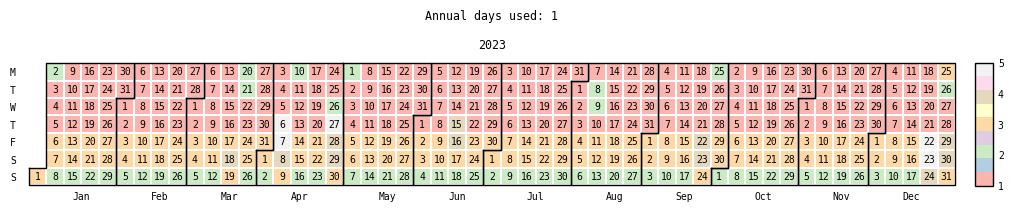

In [207]:
holiday_heatmap()
